In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts
from scipy.special import gamma
import matplotlib.pyplot as plt

In [2]:
data = np.load('lda.npz')
data_train = data['train']
data_test = data['test']

data_train = data_train[data_train[:,0]<200]
data_test = data_train[data_train[:,0]<50]

data_train[:,0] = data_train[:,0]-1
data_test[:,0] = data_test[:,0]-1
data_train[:,1] = data_train[:,1]-1
data_test[:,1] = data_test[:,1]-1

voc = max(data_train[:,1])+1
doc = max(data_train[:,0])+1


In [10]:
class PFA():
    def __init__(self,voc,doc,data_train,data_test,eta=0.5,c=1,c0=1,r0=1,gamma=1,alpha=0.05,eps=0.05,k=10):
        #initialization
        #hyperparameter
        self.eta = eta
        self.c = c
        self.c0 = c0
        self.r0 = r0
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps
        
        #number of document,word type,topic
        self.k = k #主题数量
        self.voc = voc #词汇数
        self.doc = doc #文档数
        
        #gengerative process sample
        self.phi = sts.dirichlet.rvs([self.alpha]*self.voc,size = self.k)  #Topic-word matrix  (voc * k matrix)
        self.pk = sts.beta.rvs(self.c*self.eps,self.c*(1-self.eps),size =self.k) # pk 的分布 1*k matrix
        self.rk = sts.gamma.rvs(self.c0*self.r0,scale=1/self.c0,size=self.k) #rk 1*k matrix
        self.ki = np.array([sts.gamma.rvs(self.rk,scale = self.pk/(1-self.pk)) for i in range(self.doc)]) # doc * k matrix
        
        #sampling count
        self.xik = np.zeros((self.doc,self.k)) #第i个主题第k个topic
        self.xpk = np.zeros((self.voc,self.k)) #第k个主题第p个词的数量
        self.xk = np.zeros((self.k))           #第k个topic的数量
        self.xi = np.zeros((self.doc))         #第i个文档的数量
        
        self.per_plot = []
        
        self.data_test = data_test
        self.data_train = data_train
        
    def sampler(self):
        #1.Count assignment
        for doc_word_count in self.data_train:
            
            doc_index,word_index,word_count = doc_word_count #[0,7,2]
            
            prob =   self.phi[:,word_index] * self.ki[doc_index] # 单词在每个主题的概率 * 该文档每个主题的概率
            prob/=sum(prob) 
            res = sts.multinomial.rvs(word_count,p=prob)
                
            self.xik[doc_index] += res   #第i个文档第k个topic的数量
            self.xpk[word_index] += res          #第k个主题第p个词的数量
            self.xk += res                       #第k个topic的数量
            self.xi[doc_index] += word_count     #第i个文档的数量
        
        #更新topic-doc  matrix,就是我们要替换的部分
        for topic_index in range(self.k):
            self.phi[topic_index] = sts.dirichlet.rvs([self.alpha]*self.voc + model.xpk[:,topic_index])
            
        #更新pk    
        for topic_index in range(self.k):   
            self.pk[topic_index] = sts.beta.rvs(self.c * self.eps + self.xk[topic_index] ,self.c *(1- self.eps)+ self.doc *  self.rk[topic_index] )
        
        #sample rk
        for topic_index in range(self.k):    
            if self.xk[topic_index] == 0: #当xk=0,负二项分布退化为伯努利分布
                self.rk[topic_index] = sts.gamma.rvs(self.c0 * self.r0 , scale = 1/(self.c0 - self.doc * np.log(1- self.pk[topic_index])))
            else:
                self.rk[topic_index] = sts.gamma.rvs(self.c0 * self.r0 + np.sum(self.CRT(topic_index)),scale = 1/(self.c0 - self.doc * np.log(1- self.pk[topic_index])))
        
        # sample self.ki
        for topic_index in range(self.k): 
            self.ki = sts.gamma(self.xik + self.rk,self.pk).rvs()
     
    def compute_perplexity(self):
        phi_theta = np.array([np.sum(self.phi * self.ki[doc_index].reshape(-1,1),0) for doc_index in range(self.doc)])
        phi_theta = phi_theta/np.sum(phi_theta,1).reshape(-1,1)            
        mat = np.zeros((self.doc,self.voc)) 
        for index in self.data_test:#Convert sparse to normal matrix
            mat[index[0],index[1]] = index[-1]    
        per = np.sum(mat * np.log(phi_theta))
        res = np.exp(- per/np.sum(self.data_test[:,-1]))
        self.per_plot.append(res)
        return res
    
    def CRT(self,topic): #CRT flr 
        res = np.array([sum([sts.bernoulli.rvs(self.pk[topic]/(i-1+self.pk[topic])) for i in np.linspace(1,self.xik[d][topic],self.xik[d][topic])]) for d in range(self.doc)])
        return res
    
    
    def demo(self,iteration):
        for it in range(iteration):  
            #print ('Begin {}th iterations'.format(it))
            self.sampler()
            self.compute_perplexity()
            
        sns.set()
        plt.plot(self.per_plot)
        plt.xlabel('Iteration')
        plt.ylabel('Perplexity')
        plt.show()
            

Begain 0th iterations


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


2110.6646647826933
Begain 1th iterations
2060.051444985239
Begain 2th iterations
2042.11633698878
Begain 3th iterations
2031.1267045628456
Begain 4th iterations
2026.0221272356416
Begain 5th iterations
2020.147062090794
Begain 6th iterations
2015.9356599507266
Begain 7th iterations
2013.6066399929482
Begain 8th iterations
2008.404280739899
Begain 9th iterations
2007.4220951962961
Begain 10th iterations
2004.4839882057697
Begain 11th iterations
2002.944792051876
Begain 12th iterations
2000.016368207564
Begain 13th iterations
1998.9710612158367
Begain 14th iterations
1995.1272406224793
Begain 15th iterations
1994.1925347809986
Begain 16th iterations
1992.655916249983
Begain 17th iterations
1991.210096489742
Begain 18th iterations
1991.0998556967359
Begain 19th iterations
1988.570668107014


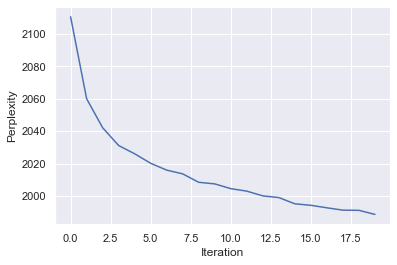

In [11]:
model = PFA(voc=voc,doc=doc,data_train=data_train,data_test = data_test)
model.demo(20)